<h1><center>Laboratorio 6: La desperación de Mr. Lepin 🐼</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Matías Rojas y Mauricio Araneda
- Auxiliar: Ignacio Meza D.
- Ayudante: Rodrigo Guerra

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Diego Cortez
- Nombre de alumno 2: Christopher Stears


### **Link de repositorio de GitHub:** `https://github.com/CHSTR/MDS7202_LAB`

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

# Temas a tratar

- Aplicar Pandas para obtener características de un DataFrame.
- Aplicar Pipelines.
- Aplicar Clusters sobre un conjunto de datos.

## Reglas:

- Fecha de entrega: 09/06/2021
- **Grupos de 2 personas**
- **Ausentes** deberán realizar la actividad solos. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.
- Código que no se pueda ejecutar, no será revisado.

### Objetivos principales del laboratorio

- Comprender y aprovechar las ventajas que nos ofrece la librería `pandas` con respecto a trabajar en Python 'puro'.
- Crear nuevas características para entrenar un modelo de clustering.
- Comprender como aplicar pipelines de Scikit-Learn para generar procesos más limpios.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `numpy`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre arreglos (*o tensores*).

## Descripción del laboratorio.

### Importamos librerias utiles 😸

In [1]:
# Libreria Core del lab.
import numpy as np
import pandas as pd
import datetime
from IPython.display import HTML

# Libreria para plotear (En colab esta desactualizado plotly)
!pip install --upgrade plotly
import plotly.express as px
import plotly.graph_objects as go

# Librerias utiles
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

In [2]:
# Si usted está utilizando Colabolatory le puede ser útil este código para cargar los archivos.
try:
    from google.colab import drive
    drive.mount("/content/drive")
    path = 'Dirección donde tiene los archivos en el Drive'
except: 
    print('Ignorando conexión drive-colab')

Ignorando conexión drive-colab


# Segmentación de Clientes en Tienda de Retail 🛍️

<p align="center">
  <img width=300 src="https://s1.eestatic.com/2018/04/14/social/la_jungla_-_social_299733421_73842361_854x640.jpg">
</p>

## 1.1 Cargar Dataset

Mr. Lepin, en una nueva reunión, le cuenta a ud y su equipo que los resultados derivados del análisis exploratorio de dato presentaron una gran utilidad para la empresa y que tiene un gran entusiasmo por continuar trabajando con ustedes.
Es por esto, que Mr. Lepin les pide que cargue y visualicen algunas de las filas que componen el Dataset.
A continuación un extracto de lo parlamentado en la reunión:

    - Usted: Es un gran logro para nuestro equipo que usted haya encontrado excelente el EDA. ¿Qué tiene en mente ahora?
    - Mr. Lepin: Resulta que hace algún tiempo, mientras tomaba un mojito en una reunión de gerentes en Panamá, oí a un *chato* acerca de **LRMFP**, que es un modelo que permite personificar a los clientes a través de la farbicación de distintos atributos que describen a los clientes. Lo encontré es-tu-pendo ñatito. 
    - Usted: Ehh bueno. Investigaremos acerca de este modelo y veremos lo que podemos hacer.

Por ende, su siguiente tarea es calcular **LRMFP** sobre cada cliente y luego hacer un análisis de las características generadas. Para esto, el área de ventas les entrega un nuevo archivo llamado `online_retail_II_cleaned.pickle`, quien posee los datos del DataFrame original limpios y listos para obtener las características solicitadas por Mr. Lepin.

In [3]:
df_retail = pd.read_pickle("online_retail_II_cleaned.pickle")
df_retail = df_retail.astype(
    {
        "Invoice": "category",
        "StockCode": "category",
        "Description": "category",
        "Description": str,
        "Customer ID": "category",
        "Country": "category"
    }
)
df_retail.head()


Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price Customer ID         Country  
0 2009-12-01 07:45:00   6.95     13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75     13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75     13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10     13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25     13085.0  United Kingdom

## 1.2 Creación de nuevas Caracteristicas [2 Puntos] 

Como ya se les comento, Mr. Lepin esta interesado en obtener las características **LRMFP**, para esto les señala que estas características se construyen en base a las siguientes definiciones:

- **Length (L)**: Intervalo de tiempo, en días, entre la primera y la última visita del cliente. Mientras mas grande sea el valor, mas fiel es el cliente.
- **Recency (R)**: Indica la actualidad de la interacción de un cliente con la empresa, y da información sobre la tendencia a repetir la compra. Se define como: 
$$Recency(n)=\dfrac{1}{n} \sum^n_{i=1} date\_diff(t_{fecha final}, t_{m-i+1})$$

 Donde $date\_diff$ representa la diferencia en días entre la fecha de finalización del periodo de observación ($t_{fecha final}$), y la fecha de una visita del cliente cercana a $t_{fecha final}$, $t_{m-i+1}; t_{m}$ es la última visita del cliente; y n es el número de visitas recientes del cliente consideradas.

- **Monetary (M)**: El término "monetario" se refiere a la cantidad media de dinero gastada por cada visita del cliente durante el período de observación y refleja la contribución del cliente a los ingresos de la empresa.

- **Frequency (F)**: Se refiere al número total de visitas del cliente durante el periodo de observación. Cuanto mayor sea la frecuencia, mayor será la fidelidad del cliente. 

- **Periodicity (P)**: Representa si los clientes visitan las tiendas con regularidad.

$$Periodicity(n)=std(IVT_1, ..., IVT_n)$$

&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Donde $IVT$ denota el tiempo entre visitas y n representa el número de valores de tiempo entre visitas de un cliente.
 

$$IVT_i=date\_diff(t_{i+1},t)$$

En base a las definiciones señaladas, diseñe una función que permita obtener las características **LRMFP** recibiendo un DataFrame como entrada. Para esto, no estará permitido el uso de iteradores, utilice todas las herramientas que les ofrece `pandas` para realizar esto.

Una referencia que le puede ser útil es el [documento original](https://www.researchgate.net/publication/315979555_LRFMP_model_for_customer_segmentation_in_the_grocery_retail_industry_a_case_study) en donde se propone este método.

**Nota:** Para la $fechafinal$ utilice la fecha máxima del dataset más 1 día.

**Ejemplo de Resultado Esperado:**

| Customer ID | Length | Recency | Frequency | Monetary | Periodicity |
|------------:|-------:|--------:|----------:|---------:|------------:|
|   12346.0   |    294 |      67 |        46 |   -64.68 |        37.0 |
|   12347.0   |     37 |       3 |        71 |  1323.32 |         0.0 |
|   12349.0   |    327 |      43 |       107 |  2646.99 |        78.0 |
|   12352.0   |     16 |      11 |        18 |   343.80 |         0.0 |
|   12356.0   |     44 |      16 |        84 |  3562.25 |        12.0 |

**Respuesta:**

In [4]:
#La función realiza los cálculos sobre el dataset agrupado por Invoice, los cuales son las visitas.
#Podría tener la mitad de las líneas de código, pero de esta forma es más eficiente (2-2.5 segundos)
#recency_n: Número de últimas fechas a considerar.
#drop_one_timers: Sólo considerar clientes con más de un invoice (con más de una visita)
def custom_features(dataframe_in, recency_n = 3, drop_one_timers=True):
    #Agrupar por Invoice genera un registro de visitas únicas. Lo calculamos una sóla vez, ahorrando cómputo 
    df_visits = dataframe_in[["Invoice", "Customer ID", "InvoiceDate"]].groupby("Invoice").last()
    
    #Output vacío con los customer ID como índice.
    df_out = dataframe_in.drop_duplicates("Customer ID").set_index("Customer ID").sort_index()[[]]
    
    #Calculamos length agrupando sobre el registro de visitas, ya que InvoiceDate es único por Invoice, ahorrando cómputo.
    df_out["Length"] = (df_visits.groupby("Customer ID")["InvoiceDate"].max() 
    - df_visits.groupby("Customer ID")["InvoiceDate"].min()).apply(lambda X:X.days)
    
    #Para recency transformamos todas las fechas a fechafinal - fecha. Lo guardamos en segundos para usarlo en Periodicity
    fechafinal = df_visits["InvoiceDate"].iloc[-1]
    df_visits["Recency"] = (fechafinal - df_visits["InvoiceDate"]).apply(lambda X:(X.days+1)*86400 + X.seconds)
    #Si N de recency es 1 el cálculo es muy sencillo y rápido, ya que es la última fecha y ahorramos cómputo.
    if recency_n ==1:
        df_out["Recency"] = df_visits.groupby("Customer ID")["Recency"].last()//86400
    else:
        df_out["Recency"] = df_visits.groupby("Customer ID")["Recency"].apply(lambda X: np.mean(X.iloc[-recency_n:]//86400))
    
    #Frequency es simplemente el número de visitas. Agrupamos por Customer ID en el DF de visitas únicas y contamos.
    df_out["Frequency"] = df_visits.groupby("Customer ID")["Recency"].count()
    
    #Para monetary, necesitamos el total gastado por entrada (quantity * price), al que llamaremos Total
    dataframe_in_copy = dataframe_in.copy()
    dataframe_in_copy["Total"] = dataframe_in_copy["Quantity"]*dataframe_in_copy["Price"]
    #Luego podemos sumar los totales agrupando por Invoice para obtener el total gastado por Compra (visita)
    df_visits["Total"] = dataframe_in_copy.groupby("Invoice")["Total"].sum()
    #Finalmente promediamos los gastos de cada visita agrupando por cliente.
    df_out["Monetary"] = df_visits.groupby("Customer ID")["Total"].mean().round(2)

    #Para periodicity agrupamos sobre Customer ID y calculamos la desviación standard de las fechas - fecha anterior.
    #Usamos recency para evitar re convertir a días, y porque la desviación standard es la misma al sumar una constante
    df_out["Periodicity"] = df_visits.groupby("Customer ID")["Recency"].apply(lambda X: np.nan if len(X)==1 else np.std(
    (X[1:].reset_index(drop=True) - X[:-1].reset_index(drop=True))//86400 )).round(1)
    
    return df_out.dropna() if drop_one_timers else df_out

df_features = custom_features(df_retail)
df_features

Length     Recency  Frequency  Monetary  Periodicity
Customer ID                                                      
12346.0         196  256.666667         11     33.90         34.8
12347.0          37   21.500000          2    661.66          0.0
12349.0         181  158.000000          3    890.38         72.0
12352.0          16   19.500000          2    171.90          0.0
12356.0          44   35.000000          3   1186.77          9.5
...             ...         ...        ...       ...          ...
18276.0         336   83.333333          5    264.13         32.3
18277.0          97   71.666667          4    267.42         33.2
18283.0         275   49.666667          6    103.23         55.3
18286.0         247  235.500000          2    648.22          0.0
18287.0         188   59.333333          4    586.43         51.9

[2893 rows x 5 columns]

In [5]:
df_features.describe()

Length      Recency    Frequency     Monetary  Periodicity
count  2893.000000  2893.000000  2893.000000  2893.000000  2893.000000
mean    199.724162   114.130199     6.150709   389.428801    25.572382
std     114.753446    81.172802     9.527428   421.742733    28.593282
min       0.000000     1.000000     2.000000    10.820000     0.000000
25%     103.000000    45.000000     2.000000   199.930000     0.000000
50%     209.000000    99.000000     4.000000   300.940000    18.400000
75%     301.000000   167.500000     7.000000   440.310000    38.600000
max     373.000000   374.000000   205.000000  7488.900000   180.500000

**Respuesta de Pauta:**

Vemos que se obtienen los distintos atributos de los clientes. 

A la fecha y en un período de observación de 1 año, el promedio de los clientes de la base de datos ha permanecido por 200 días, con última compra hace 62 días, con 6 compras anuales, gasta en promedio 389 por compra y la desviación estandard del intervalo entre compras es de 26 días.

## 1.3 Pipelines 👷

Finalmente *Don Mora* le pregunta si seria posible realizar un pipeline para realizar una segmentación de los clientes con los nuevos datos generados, a lo que usted responde que **sí** y propone la utilización de k-means para la segmentación.

A continuación siga los pasos requeridos para obtener la segmentación de clientes.

### 1.3.1 Estandarizar Caracteristicas [0.5 puntos]

Construya una clase llamada ``MinMax()`` utilizando ``BaseEstimator`` y ``TransformerMixin`` para realizar una transformación de cada una de las columnas de un DataFrame utilizando ``ColumnTransformer()`` más tarde (tome como referencia el siguiente [enlace](https://sklearn-template.readthedocs.io/en/latest/user_guide.html#transformer)).


 Para esto considere que Min-Max escaler queda dada por la ecuación:

$$MinMax = \dfrac{x-min(x)}{max(x) - min(x)}$$

Con esto buscamos que los valores que componen a las columnas se muevan en el rango de valores $[0, 1]$.

**Respuesta:**

In [6]:
class MinMax(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        min_x = X.min()
        max_x = X.max()
        
        min_max = (X - min_x)/(max_x - min_x)
        
        return min_max

In [7]:
# https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
columns = ["Length", "Recency", "Frequency", "Monetary", "Periodicity"]
ct = ColumnTransformer([
    ("MinMax", MinMax(), columns)
])

pipeline = Pipeline(steps=[('MinMax', ct)])

In [8]:
df_retail_tf = pipeline.fit_transform(custom_features(df_retail))
df_retail_tf

array([[0.52546917, 0.68543342, 0.04433498, 0.00308635, 0.19279778],
       [0.09919571, 0.05495979, 0.        , 0.08703304, 0.        ],
       [0.48525469, 0.42091153, 0.00492611, 0.11761843, 0.39889197],
       ...,
       [0.73726542, 0.13047364, 0.01970443, 0.01235745, 0.30637119],
       [0.66219839, 0.62868633, 0.        , 0.08523578, 0.        ],
       [0.50402145, 0.15638963, 0.00985222, 0.07697297, 0.28753463]])

### 1.3.2 `T-SNE` Pipeline [1.0 puntos]

Para comenzar introduciéndose en el uso de pipeline, decide probar realizando un pipeline enfocado en la reducción de dimensionalidad y así hacer no decepcionar a Mr. Lepin con la clusterización del modelo. 

Configure un pipeline utilizando el algoritmo `T-SNE` sobre los datos **LRMFP**, donde, para la realización del pipeline considera los siguientes pasos:

1. Como primer paso obtenga las características **LRMFP** desde el DataFrame ``df_retail_II_cleaned.pickle`` utilizando la función ``custom_features`` creada anteriormente, junto a ``FunctionTransformer()``. Considere esto como el primer paso de su pipeline.
2. En segundo lugar usando ``ColumnTransformer()`` aplique el MinxMax scaler creado por usted sobre todas las columnas generadas en el paso anterior. 
3. Finalmente, aplique un último paso donde obtiene las 2 componentes más relevantes utilizando el algoritmo T-sne de sckit-learn.

Tras aplicar las transformaciones sobre el dataset **LRMFP**, gráfique las componentes obtenidas en la reducción de dimensionalidad.

**Respuesta:**

In [9]:
class LRMFP(BaseEstimator, TransformerMixin):
    def __init__(self, recency_n = 1):
        self.recency_n = recency_n
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return custom_features(X, recency_n = self.recency_n)

pipeline = Pipeline(steps=[
    ('LRMFP', LRMFP(recency_n=3)), 
    ('MinMax', ct), 
    ("TSNE", TSNE(n_components=2, init = 'pca', learning_rate = 'auto'))
])

transformed_features = pipeline.fit_transform(df_retail)

/home/chr/tmp/deep_learning/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [10]:
df_features = custom_features(df_retail, recency_n =3)

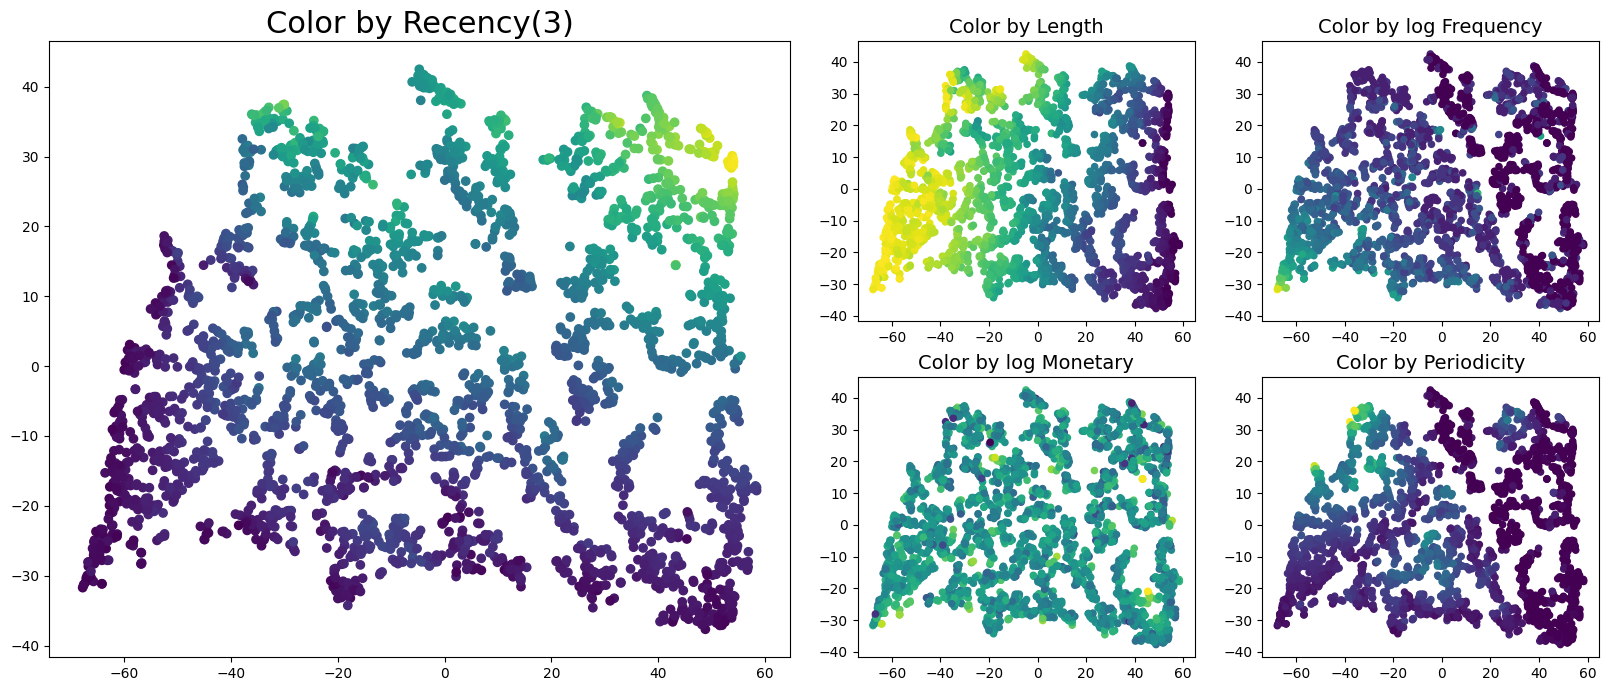

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(20,8))
gs = axes[0, 0].get_gridspec()

for ax in axes[:, :2].flatten():
    ax.remove()
axbig = fig.add_subplot(gs[:, :2])

axbig.scatter(transformed_features[:,0], transformed_features[:,1], c=(df_features["Recency"]))
axbig.set_title(f"Color by Recency(3)", size=22)

for ax, feature, fun in zip(axes[:, 2:].flatten(), ["Length", "Frequency", "Monetary", "Periodicity"], 
                            [lambda X:X, np.log, np.log, lambda X:X]):
    ax.scatter(transformed_features[:,0], transformed_features[:,1], c=fun(df_features[feature]), s=20)
    ax.set_title(f"Color by {'log ' if fun is np.log else ''}{feature}", size=14)

plt.show()

Para la extracción de atributos `LRMFP` utilizamos `recency_n=3` ya que concideramos que utilizar el promedio de las 3 últimas visitas para estimar si el cliente sigue activo es más consistente que sólo considerar la última.

Podemos observar que los clientes con menor `Recency(3)`, es decir aquellos que compraron más recientemente se agrupan en el extremo inferior izquierdo de la representación bidimensional de T-SNE. Estos coinciden con aquellos con mayor `Length` y `Frequency` y constituyen una serie de clusters que podrían representar los 'mejores clientes'.

El indicador `Periodicity` es bajo (indicativo de alta regularidad) tanto en estos 'buenos clientes' como en aquellos al otro extremo, que son aquellos que sólo compraron un par de veces (Baja frecuencia y length), y que al tener sólo 1 intervalo de tiempo entre visitas su desviación estandard es 0.

Por su parte, `Monetary` parece no estar correlacionado con el resto de las características, de manera tal que hay clientes frecuentes que gastan mucho en promedio y otros que gastan poco.

### 1.3.3 Clustering

#### 1.3.3.1 Método del Codo [1 puntos]

Utilizando la clase creada para escalamiento, aplique el método del codo para visualizar cual es el número de clusters que mejor se ajustan a los datos. Realice esto utilizando el algoritmo K-means dentro de un pipeline para un $k \in [1,20]$, donde k representa el número de clusters del k-means. Para la realización de esta sección y la próxima (1.3.3.2), considere los mismos pasos utilizados para el t-sne, pero permutando el algoritmo de reducción de dimensionalidad por k-means.

A través del grafico obtenido, comente y justifique que valor de k escogería para realizar el k-means.

**Respuesta:**

In [12]:
from sklearn.cluster import KMeans

SEED = 86

pipeline = Pipeline([('LRMFP', FunctionTransformer(custom_features)), ("MinMax", ct)])
df_retail_tf = pipeline.fit_transform(df_retail)

intertias = [
    [i, KMeans(n_clusters=i, random_state=SEED).fit(df_retail_tf).inertia_]
    for i in range(1, 20)
]

intertias_df = pd.DataFrame(intertias, columns=["n_clusters", "inertia"])

In [13]:
px.line(
    intertias_df,
    x="n_clusters",
    y="inertia",
    title="Método del codo con K-Means"
)

A primera vista, del gráfico logran observar 2 quiebres que nos podrían indicar el número de cluster a utilizar. El primero es más pronunciado y se presenta al utilizar 2 clusters. El segundo y menos pronunciado se presenta al utilizar 5. Como no queda claro la cantidad de clusters a utilizar con el método del codo, se utilizará el coeficiente de silhouette para complementar la información que se tiene.

In [14]:
from sklearn.metrics import silhouette_samples, silhouette_score

scores = [
    [
        cluster,
        silhouette_score(
            df_retail_tf,
            KMeans(n_clusters=cluster, random_state=SEED).fit(df_retail_tf).labels_,
        ),
    ]
    for cluster in range(2, 20)
]

scores = pd.DataFrame(scores, columns=["n_clusters", "silhouette_score"])

In [15]:
px.line(
    scores,
    x="n_clusters", 
    y="silhouette_score",
    title="Coeficiente de Silhouette"
)

Si bien, ninguno de los valores está cercano a 1, podemos observar cómo con 5 clusters el coeficiente de silhouette aumenta, valor que calza con el método del codo. Por lo tanto, se escogerá un número de cluster igual a 5.

#### 1.3.3.2 Segmentación de Clientes con K-Means 🎁 [1 punto]

En base a la elección de k realizada en la sección anterior, utilice este valor escogido y entrene un modelo de K-means utilizando el mismo pipeline de scikit-learn utilizado anteriormente.

Una vez ajustado los datos, genere una tabla con los promedios (o medianas) para cada uno de los atributos, agrupando estos por el clúster que pertenecen. ¿Es posible observar agrupaciones coherentes?, ¿Qué tipo de clientes posee el retail?, Justifique su respuesta y no decepcione a Mr. Lepin.


**Respuesta:**

In [16]:
kmeans_5 = KMeans(n_clusters=5, random_state=SEED).fit(df_retail_tf)

In [17]:
cf = custom_features(df_retail)
cf.insert (5, "Cluster", kmeans_5.labels_ )

In [18]:
cf.groupby("Cluster").mean()

Length     Recency  Frequency    Monetary  Periodicity
Cluster                                                            
0        329.675793   46.076369  14.047550  442.403934    28.272911
1        214.054087  134.291066   4.264423  365.922692    22.560096
2         60.266667   63.308010   3.153488  388.786388     6.680465
3        289.298817  145.524655   4.079882  362.997219    81.465385
4         89.216146  251.173177   2.822917  368.961536     9.753385

Es posible observar valores que tienen sentido. Como vemos, aquellas agrupaciones que presentan un `Length` más grande, también presentan una alta '`Frequency`'. Un comportamiento similar sucede para aquellos valores pequeños de `Length`. Además, cada uno de los clusters presenta valores interesantes a analizar:

- En cluster 0 se encuentran aquellos clientes más fieles, que más frecuentan la tienda y que más dinero gastan por visita. Además, este grupo presenta el `Recency` más bajo, lo que indica que existe una alta probabilidad de que vuelvan a comprar.
- Los cluster 1 y 3 tienen varias similitudes. Como vemos, en ambos se tienen clientes fieles a la tienda, cuya tendencia para repetir su compra es relativamente baja (134 y 145 respectivamente). La mayor diferencia entre los grupos radica en su `Periodicity`, donde el cluster 1 suele realizar compras a intervalos relativamente regulares en comparación del cluster 3.
- Finalmente, en los clusters 2 y 4 engloba a aquellos clientes menos fieles, que menos frecuentan la tienda y que cuyas compras son irregulares, aún así presentan un alto gasto por visita. La diferencia entre los grupos se presenta en `Recency`, donde el cluster 2 es más propenso a volver a comprar, no así el grupo 4, que presenta el valor promedio más alto.

**Respuesta Esperada:**

|         | Length  | Recency   | Frequency | Monetary | Periodicity |       |
|---------|---------|-----------|----------|-------------|-------|-------|
| Cluster |         |           |          |             |       |       |
|    0    |   258.8 |      45.2 |     76.1 |      1107.7 | 107.6 |   449 |
|    1    |    76.1 |     217.6 |     45.5 |       791.7 |  14.1 |   466 |
|    2    |   368.5 |       4.8 |   2715.0 |    226621.6 |   4.2 |     4 |
|    3    |    85.3 |      45.7 |     65.8 |      1047.0 |  10.5 |   987 |
|    4    |   347.2 |      15.9 |   1658.0 |     35829.3 |   8.0 |    25 |
|    5    |   298.0 |      29.8 |    183.8 |      3639.9 |  32.0 |  1188 |

#### 1.3.3.3 Plot de K-Means 📈 [0.5 puntos]



Por último, Mr. Lepin, impaciente de no entender lo que usted intenta explicarle, le solicita que por favor muestre algún resultado "visual" de los grupos encontrados.

Para esto, grafique nuevamente las características encontradas usando `T-SNE` (no calcule de nuevo, simplemente utilice las proyecciones encontradas) y agregue las labels calculadas con kmeans como el argumento `color`.   

Comente: ¿Se separan bien los distintos clusters en la visualización?


**Respuesta:**

In [19]:
df_final = pd.DataFrame(transformed_features, columns=["x", "y"])
df_final['Cluster'] = kmeans_5.labels_

In [20]:
px.scatter(
    df_final,
    x="x",
    y="y",
    color='Cluster',
)

Se logran identificar los 5 clusters, y vemos cómo aquellos clientes que presentan mayor fidelidad al retail tienden a estar a la izquierda del gráfico (cluster 0, 1 y 3), y aquellos grupos que son más propensos a volver a comprar se ubican en la zona inferior del mismo.

Sin embargo, vemos que no necesariamente se separan del todo bien, ya que hay valores del cluster 3 dentro del cluster 1, y lo mismo sucede con el cluster 4. Además, y observando los datos, sería interesante no solo quedarnos con esta clusterización, sino también intentar algoritmos de clustering basados en densidad y así complementar lo anterior.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana y que **los días de atraso no se pueden utilizar para entregas de lab** solo para tareas. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://i.pinimg.com/originals/65/ae/27/65ae270df87c3c4adcea997e48f60852.gif "bruno")


<br>
<center>
<img src="https://i.kym-cdn.com/photos/images/original/001/194/195/b18.png" width=100 height=50 />
</center>
<br>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>